### GATHERING DATA
---

In [ ]:
!pip install tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing the necessary packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import json
from tweepy import OAuthHandler
from timeit import default_timer as timer
import configparser
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [ ]:
# reading the twitter_enhanced.csv files 
twitter_enhanced_archive = pd.read_csv('twitter-archive-enhanced.csv')
# twitter_enhanced_archive.head(2)

In [ ]:
# using request to download image_prediction.tsv programatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_\
image-predictions/image-predictions.tsv'

response = requests.get(url)

# writing the downloaded file
file_name = 'image_prediction.tsv'
with open(file_name, mode = 'wb') as file:
    file.write(response.content)

In [ ]:
image_prediction = pd.read_csv('image_prediction.tsv', sep='\t')
# image_prediction.head()

In [ ]:
# Reading the config parser file 
# created to contain twitter authentication credentials

config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

# authentication of twitter account
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

# making an api instant
api = tweepy.API(auth, wait_on_rate_limit=True)

tweet_ids = twitter_enhanced_archive.tweet_id.values
tweet_ids.size

2356

The following codes were adopted and modified from the udacity classroom

In [ ]:
# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# ids_with_no_tweets = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as file:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             list_of_tweets = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(list_of_tweets._json, file)
#             file.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             ids_with_no_tweets[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(ids_with_no_tweets)

In [ ]:
# reading JSON file
tweet_list = []
with open('tweet_json.txt') as file:
  for line in file:
    tweet_list.append(json.loads(line))

In [ ]:
#reading json file dataframe
tweet_df = pd.DataFrame(tweet_list , columns = ['id' , 'retweet_count' , 'favorite_count'])
tweet_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing the Data 
- This stage will look at each of the three dataframes under two headings
  - Quality: Data quality issues include:
    - missing values
    - duplicate values
    - incorrect date types
    - outliers, etc
  - Tidiness: Data tidiness will look at the structural issues associated with each of the dataframes

**Summary of quality issues identified with the twitter_archive_enhanced data**

---
- The tweet_id column is supposed to be **string** not **int**
- Timestamp data type is supposed to be **datetime** instead of object
- Dog name **floof** was spelt as **floofer**
- It is observed that some of the denominators of the rating_denominator column are either less than or greater than than
- Some values in the rating_numerator are less than 10
- Some other values in the rating_numerator column are excessively too huge
- Some **texts in the text column** have **urls** attached to them
- The expanded_urls column has 59 null values
- Some of the names under the name column are labelled none which are more likely null values
- Some names like (a) in the names column are not very meaningful
- The following columns would not be relevant to our analysis since our focus is on tweets on retweets: 
    - retweeted_status_id
    - retweeted_status_user_id
    - retweeted_status_timestamp
    - in_reply_to_status_id
    - in_reply_to_user_id 

---

**Summary of quality issues identified with the image_prediction data**

---
- The data type for tweet_id must object intead of int
- There are both upper and lower case for columns p1, p2 and p3


---

**Summary of quality issues identified with the tweet data**

---
- The id column is supposed to be object instead of int64
- id should be changed to conform to id names in previous dataframes


**Tidiness issues identified with the archive data**
- Some of the rows in the expanded_urls column have more than one link
- Numerator and denominator should be in same the column
- Some texts have urls attached to them

---


#### Assessing Twitter Archive data

In [ ]:
# getting the first five rows of the archive data
twitter_enhanced_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [ ]:
# getting the last five rows of the archive data
twitter_enhanced_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [ ]:
# assessing the descriptive statistics of the twitter archive data
twitter_enhanced_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

- timestamp is supposed to be datetime

In [ ]:
# checking for null values in the archive data
twitter_enhanced_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [ ]:
# assessing if the twitter archive data has duplicated rows
twitter_enhanced_archive.duplicated().sum()

0

In [ ]:
# assessing a sample of the archive data
twitter_enhanced_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1330,705786532653883392,7.032559e+17,4.196984e+09,2016-03-04 16:06:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Seriously, add us 🐶 11/10 for sad wet pupper h...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/705786532...,11,10,None,None,None,pupper,None
2315,666691418707132416,NaN,NaN,2015-11-17 18:56:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Christoper. He is a spotted Penne. Can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666691418...,8,10,Christoper,None,None,None,None
627,794983741416415232,NaN,NaN,2016-11-05 19:24:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Rizzy. She smiles a lot...,7.895309e+17,4.196984e+09,2016-10-21 18:16:44 +0000,https://twitter.com/dog_rates/status/789530877...,12,10,Rizzy,None,None,None,None
2148,669749430875258880,NaN,NaN,2015-11-26 05:28:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Clarence. Clarence thought he saw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669749430...,8,10,Clarence,None,None,None,None
1732,679828447187857408,NaN,NaN,2015-12-24 00:58:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Everybody look at this beautiful pupper 13/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679828447...,13,10,None,None,None,pupper,None
207,852553447878664193,NaN,NaN,2017-04-13 16:05:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jarod. He likes having his belly brush...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/852553447...,13,10,Jarod,None,None,None,None
1668,682638830361513985,NaN,NaN,2015-12-31 19:05:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have no words. Just a magnificent pup. 12/10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682638830...,12,10,None,None,None,None,None
1279,708845821941387268,NaN,NaN,2016-03-13 02:43:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a pupper with magic eyes. Not wearing a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708845821...,9,10,None,None,None,pupper,None
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None
970,750117059602808832,NaN,NaN,2016-07-05 00:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Calvin. He just loves America so much....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750117059...,10,10,Calvin,None,None,None,None


In [ ]:
# assessing the value counts of the archive data
twitter_enhanced_archive.value_counts()

Series([], dtype: int64)

In [ ]:
# checking the denominators of the rating_denominator column
twitter_enhanced_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [ ]:
# checking the numerators of the rating_denominator column
twitter_enhanced_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [ ]:
# checking to see if all the urls in the expanded url column have only one url
twitter_enhanced_archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/667152164079423490/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/718631497683582976/photo/1                                                                                                                                                                                                    2
https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1                                                                    2
https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_rates/status/774314403806253056/photo/1,https://twitter.com/dog_r

**Summary of quality issues identified with the twitter_archive_enhanced data**

---
- The tweet_id column is supposed to be **string** not **int**
- Timestamp data type is supposed to be **datetime** instead of object
- Dog name **floof** was spelt as **floofer**
- It is observed that some of the denominators of the rating_denominator column are either less than or greater than than
- Some values in the rating_numerator are less than 10
- Some other values in the rating_numerator column are excessively too huge
- Some **texts in the text column** have **urls** attached to them
- The expanded_urls column has 59 null values
- Some of the names under the name column are labelled none which are more likely null values
- Some names like (a) in the names column are not very meaningful
- The following columns would not be relevant to our analysis since our focus is on tweets on retweets: 
    - retweeted_status_id
    - retweeted_status_user_id
    - retweeted_status_timestamp
    - in_reply_to_status_id
    - in_reply_to_user_id 

---
**Tidiness issues identified with the archive data**
- Some of the rows in the expanded_urls column have more than one link
- Numerator and denominator should be in same the column

---


### **Assessing the image prediction data**

In [ ]:
# Assessing the first five rows of the image prediction data
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [ ]:
# getting the last five rows of the image prediction data
image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [ ]:
# assessing the descriptive statistics of the image_prediction data 
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [ ]:
# checking for if the image_prediction data has null values
image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [ ]:
# assessing if the image_prediction data has duplicated rows
image_prediction.duplicated().sum()

0

In [ ]:
# assessing a random sample of the image prediction data
image_prediction.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
504,675888385639251968,https://pbs.twimg.com/media/CWE85snWIAEG5ES.jpg,1,West_Highland_white_terrier,0.672117,True,Old_English_sheepdog,0.146147,True,komondor,0.023141,True
101,667793409583771648,https://pbs.twimg.com/media/CUR6jqVWsAEgGot.jpg,1,dalmatian,0.535073,True,English_setter,0.451219,True,Great_Dane,0.008164,True
1527,788908386943430656,https://pbs.twimg.com/media/CvLD-mbWYAAFI8w.jpg,1,remote_control,0.881538,False,oscilloscope,0.035513,False,golden_retriever,0.034090,True
389,673359818736984064,https://pbs.twimg.com/media/CVhBLohWEAAXtYl.jpg,1,English_setter,0.696568,True,Brittany_spaniel,0.104046,True,Ibizan_hound,0.034832,True
1502,784517518371221505,https://pbs.twimg.com/media/CuMqhGrXYAQwRqU.jpg,2,malamute,0.757764,True,Eskimo_dog,0.151248,True,Siberian_husky,0.084840,True
1755,824796380199809024,https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg,2,gas_pump,0.676439,False,harvester,0.049995,False,swing,0.044660,False
1383,765669560888528897,https://pbs.twimg.com/media/CqA0XcYWAAAzltT.jpg,1,beagle,0.993333,True,Walker_hound,0.002902,True,basset,0.002415,True
360,672640509974827008,https://pbs.twimg.com/media/CVWy9v-VAAALSoE.jpg,1,Chesapeake_Bay_retriever,0.420155,True,Cardigan,0.266030,True,Labrador_retriever,0.042514,True
1302,752917284578922496,https://pbs.twimg.com/media/CnLmRiYXEAAO_8f.jpg,1,German_shepherd,0.609283,True,malinois,0.352460,True,kelpie,0.016105,True
1715,819004803107983360,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,0.094759,True


In [ ]:
# checking the value count of the image data
image_prediction.value_counts()

tweet_id            jpg_url                                          img_num  p1                      p1_conf   p1_dog  p2                           p2_conf   p2_dog  p3                        p3_conf   p3_dog
666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg  1        Welsh_springer_spaniel  0.465074  True    collie                       0.156665  True    Shetland_sheepdog         0.061428  True      1
761292947749015552  https://pbs.twimg.com/media/CpCn5aXXgAAOPTm.jpg  1        standard_poodle         0.660893  True    Samoyed                      0.314886  True    miniature_poodle          0.008834  True      1
767122157629476866  https://pbs.twimg.com/media/CqVdiBJWIAEDZB4.jpg  2        toy_poodle              0.873841  True    miniature_poodle             0.059192  True    Irish_terrier             0.035306  True      1
766793450729734144  https://pbs.twimg.com/media/CqQykxrWYAAlD8g.jpg  1        beagle                  0.451697  True    basset                   

**Summary of quality issues identified with the image_prediction data**

---
- The data type for tweet_id must object intead of int
- There are both upper and lower case for columns p1, p2 and p3


---

### Assessing the Tweet data downloaded via API
---

In [ ]:
# checking for the first five rows
tweet_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [ ]:
# checking for the last five rows
tweet_df.tail()

,id,retweet_count,favorite_count
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132
2353,666020888022790149,532,2535


In [ ]:
# checking for the descriptive statistics of the data
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [ ]:
# checking for missing values
tweet_df.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

In [ ]:
# checking for duplicated values
tweet_df.duplicated().sum()

0

In [ ]:
# checking for value counts
tweet_df.value_counts()

id                  retweet_count  favorite_count
666020888022790149  532            2535              1
776249906839351296  10673          0                 1
773985732834758656  4492           11925             1
774314403806253056  6478           24167             1
774639387460112384  2013           7508              1
                                                    ..
687732144991551489  750            1935              1
687807801670897665  801            2625              1
687818504314159109  1080           2758              1
687826841265172480  1292           2989              1
892420643555336193  8853           39467             1
Length: 2354, dtype: int64

**Summary of quality issues identified with the tweet data**

---
- The id column is supposed to be object instead of int64
- id should be changed to conform to id names in previous dataframes

---
**All the three datasets would be merged into one and named we_rate_df**

---

## **CLEANING THE DATA**
---
- In this session of our data wrangling, we would implement implement the correction of issues identified when assessing the datasets
- The format of the cleaning would take the form of:
  - Define
  - Code
  - Test
- We would first start by making a copy of the three datasets



## **Handling cleaning for the twitter-archive-enhanced dataset**

In [ ]:
# Making a copy of the three datasets
archive = twitter_enhanced_archive.copy()
image_pred = image_prediction.copy()
tweets = tweet_df.copy()

**Define**

---
Correcting the data types of **tweet_id to string and timestamp to datetime64**

**Code**

In [ ]:
# correcting the datatypes
archive['tweet_id'] = archive['tweet_id'].astype(str)
archive.timestamp = archive.timestamp.astype('datetime64')

### **Test**

In [ ]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

### **Define**
Renaming floofer column to floof

### **Code**

In [ ]:
# Renaming floofer to floof
archive.rename(columns={'floofer':'floof'}, inplace =True)


### **Test**

In [ ]:
archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### **Define**

striping off **url links** from the **texts** in the text column

### **Code**

In [ ]:
archive['text'] = archive.text.str.replace("&amp;", "&")
archive['text'] = archive.text.str.replace("\n", " ")
archive['text'] = archive.text.str.replace(r"http\S+", "")
archive['text'] = archive.text.str.replace('10',"")
archive['text'] = archive.text.str.strip()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


### **Test**

In [ ]:
text = archive.text
print('&amp' in text)
print("\n" in text)
print("http\S+" in text )
print('10' in text)





False
False
False
False


### **Define**

---
Replacing denominator values less or greater than 10 with 10

### **Code**

In [ ]:
archive.rating_denominator.replace(range(0,200),10, inplace = True)

### **Test**

In [ ]:
archive.rating_denominator.value_counts()

10    2356
Name: rating_denominator, dtype: int64

### **Define**

---
- Drop rows with numerators greater than 20
- Replace ratings lower than 10 with 10

### **Code**

In [ ]:
# Replacing numerators less than 10 with 10
archive.rating_numerator.replace(range(0, 10), 10, inplace = True)


# Selecting rating numerators less than or equal to 20
archive = archive.loc[archive['rating_numerator']<= 20]

### **Test**

In [ ]:
archive.rating_numerator.value_counts()

10    901
12    558
11    464
13    351
14     54
15      2
17      1
20      1
Name: rating_numerator, dtype: int64

### **Define**


Unifying names in the name column by replacing None with Null

### **Code**

In [ ]:
archive['name'].replace(to_replace='None' , value = np.nan,inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### **Test**


In [ ]:
# checking for "none" in archive
'None' in archive.name.values

False

### **Define**
Dropping irrelevant columns. These columns also have more than half of their values blank 

### **Code**

In [ ]:
archive.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'], axis = 1, inplace = True) 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### **Test**

In [ ]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2332 non-null   object        
 1   timestamp           2332 non-null   datetime64[ns]
 2   source              2332 non-null   object        
 3   text                2332 non-null   object        
 4   expanded_urls       2277 non-null   object        
 5   rating_numerator    2332 non-null   int64         
 6   rating_denominator  2332 non-null   int64         
 7   name                1603 non-null   object        
 8   doggo               2332 non-null   object        
 9   floof               2332 non-null   object        
 10  pupper              2332 non-null   object        
 11  puppo               2332 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 236.8+ KB


## **Image prediction dataset**

### **Define**
Change the data type of tweet_id from int to str


## **Code**

In [ ]:
# changing the datatype of tweet_id to string
image_pred['tweet_id'] = image_pred['tweet_id'].astype(str)

## **Test**

In [ ]:
# checking if the code has worked
image_pred.tweet_id.dtype

dtype('O')

### **Define**
unifying all alpahabet in the p1, p2, p3 column

### **Code**

In [ ]:
image_pred['p1'] = image_pred['p1'].str.lower()
image_pred['p2'] = image_pred['p2'].str.lower()
image_pred['p3'] = image_pred['p3'].str.lower()

Test

In [ ]:
image_pred.loc[:,['p1','p2','p3']].head()

,p1,p2,p3
0,welsh_springer_spaniel,collie,shetland_sheepdog
1,redbone,miniature_pinscher,rhodesian_ridgeback
2,german_shepherd,malinois,bloodhound
3,rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,rottweiler,doberman


## **Tweets Dataset**

### **Define**
Change **"id"** data type to **string**


### **Code**

In [ ]:
tweet_df['id'] = tweet_df['id'].astype('str')

### **Test**

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


### **Define**
Replacing "id" with "tweet_id" for conformity 

### **Code**

In [ ]:
# replace "id" with "tweet_id"
tweet_df.rename(columns={'id': 'tweet_id'},  inplace=True, errors='raise')

### **Test**

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


**MERGING THE THREE DATASETS INTO ONE DATAFRAME**

### **Define**
Merging the data sets on tweet id

### **Code**

In [ ]:
archive_merge = pd.merge(archive,image_pred, how = 'left',on = 'tweet_id')

In [ ]:
final_merge = pd.merge(archive_merge,tweet_df, how ='left',on ='tweet_id')

### **Test**

In [ ]:
final_merge.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,9774.0,41048.0


In [ ]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2331
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2332 non-null   object        
 1   timestamp           2332 non-null   datetime64[ns]
 2   source              2332 non-null   object        
 3   text                2332 non-null   object        
 4   expanded_urls       2277 non-null   object        
 5   rating_numerator    2332 non-null   int64         
 6   rating_denominator  2332 non-null   int64         
 7   name                1603 non-null   object        
 8   doggo               2332 non-null   object        
 9   floof               2332 non-null   object        
 10  pupper              2332 non-null   object        
 11  puppo               2332 non-null   object        
 12  jpg_url             2056 non-null   object        
 13  img_num             2056 non-null   float64     

**Creating a new column "tweet_day to help in our analysis**

In [ ]:
# creating tweet_day from timestamp
final_merge['tweet_day'] = pd.to_datetime(final_merge['timestamp']).dt.day_name()

final_merge.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,tweet_day
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,Tuesday
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,True,pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,Tuesday


## **Storing the merged data**

In [ ]:
# Storing the merged data with a new name twitter_archive_master

final_merge.to_csv('twitter_archive_master.csv', index = False)

## **Analyzing of the Data** 

In [ ]:
# creating a copy of the master dataframe for analysis
df = pd.read_csv('twitter_archive_master.csv').copy()
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,tweet_day
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,...,False,bagel,0.085851,False,banana,0.076110,False,8853.0,39467.0,Tuesday
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,...,True,pekinese,0.090647,True,papillon,0.068957,True,6514.0,33819.0,Tuesday
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328.0,25461.0,Monday
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,...,False,labrador_retriever,0.168086,True,spatula,0.040836,False,8964.0,42908.0,Sunday
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,...,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,9774.0,41048.0,Saturday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2332 non-null   int64  
 1   timestamp           2332 non-null   object 
 2   source              2332 non-null   object 
 3   text                2332 non-null   object 
 4   expanded_urls       2277 non-null   object 
 5   rating_numerator    2332 non-null   int64  
 6   rating_denominator  2332 non-null   int64  
 7   name                1603 non-null   object 
 8   doggo               2332 non-null   object 
 9   floof               2332 non-null   object 
 10  pupper              2332 non-null   object 
 11  puppo               2332 non-null   object 
 12  jpg_url             2056 non-null   object 
 13  img_num             2056 non-null   float64
 14  p1                  2056 non-null   object 
 15  p1_conf             2056 non-null   float64
 16  p1_dog

In [ ]:
# changing tweet id to string
df.tweet_id = df.tweet_id.astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2332 non-null   object 
 1   timestamp           2332 non-null   object 
 2   source              2332 non-null   object 
 3   text                2332 non-null   object 
 4   expanded_urls       2277 non-null   object 
 5   rating_numerator    2332 non-null   int64  
 6   rating_denominator  2332 non-null   int64  
 7   name                1603 non-null   object 
 8   doggo               2332 non-null   object 
 9   floof               2332 non-null   object 
 10  pupper              2332 non-null   object 
 11  puppo               2332 non-null   object 
 12  jpg_url             2056 non-null   object 
 13  img_num             2056 non-null   float64
 14  p1                  2056 non-null   object 
 15  p1_conf             2056 non-null   float64
 16  p1_dog

In [ ]:
# setting timestamp as the index
df = df.set_index('timestamp')

In [ ]:
# taking a sample of the master dataframe
df.sample(5)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,pupper,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,tweet_day
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-19 18:39:13,689517482558820352,"<a href=""http://twitter.com/download/iphone"" r...",This is Carl. He just wants to make sure you'r...,https://twitter.com/dog_rates/status/689517482...,12,10,Carl,None,None,None,...,True,cardigan,0.189537,True,papillon,0.003386,True,1609.0,3735.0,Tuesday
2015-11-30 15:59:17,671357843010908160,"<a href=""http://twitter.com/download/iphone"" r...",Tfw she says hello from the other side. 9/,https://twitter.com/dog_rates/status/671357843...,10,10,NaN,None,None,None,...,True,toy_terrier,0.043306,True,chihuahua,0.036773,True,157.0,426.0,Monday
2016-03-14 23:19:03,709519240576036864,"<a href=""http://twitter.com/download/iphone"" r...",This is Vince. He's a Gregorian Flapjeck. Whit...,https://twitter.com/dog_rates/status/709519240...,10,10,Vince,None,None,None,...,True,newfoundland,0.225482,True,flat-coated_retriever,0.196789,True,277.0,1620.0,Monday
2016-06-01 00:17:54,737800304142471168,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She's ubering home after a few ...,https://twitter.com/dog_rates/status/737800304...,10,10,Bella,None,None,None,...,True,norwegian_elkhound,0.334853,True,limousine,0.068173,False,3904.0,10943.0,Wednesday
2017-04-05 00:04:08,849412302885593088,"<a href=""http://twitter.com/download/iphone"" r...",This is Noosh. He noticed you were in the show...,https://twitter.com/dog_rates/status/849412302...,12,10,Noosh,None,None,None,...,True,crossword_puzzle,0.017934,False,chihuahua,0.016191,True,3487.0,17039.0,Wednesday


---

**Taking a summary Statistics of the master data to assess the confidence level of the predictions and their distributions**

---

In [ ]:
df.describe().round(5)

,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
count,2332.00000,2332.0,2056.00000,2056.00000,2056.00000,2056.00000,2330.00000,2330.00000
mean,11.23328,10.0,1.20477,0.59442,0.13499,0.06030,3178.54549,8116.81888
std,1.20258,0.0,0.56361,0.27129,0.10077,0.05084,5306.66173,11862.20798
min,10.00000,10.0,1.00000,0.04433,0.00000,0.00000,0.00000,0.00000
25%,10.00000,10.0,1.00000,0.36327,0.05412,0.01617,624.50000,1411.50000
50%,11.00000,10.0,1.00000,0.58862,0.11925,0.04934,1477.00000,3607.00000
75%,12.00000,10.0,1.00000,0.84380,0.19633,0.09198,3652.00000,10189.75000
max,20.00000,10.0,4.00000,1.00000,0.48801,0.27104,79515.00000,132810.00000


In [ ]:
# creating a bin for the confidence intervals
bin_edges = [0.025, 0.05, 0.075, 1.0]

# creating bin labels
bin_labels = ['below 2.5%', 'below 5%', 'above 5%']

# creating bin groups for each category
df['p1_conf_group'] = pd.cut(df['p1_conf'], bin_edges, labels = bin_labels, include_lowest = True)
df['p2_conf_group'] = pd.cut(df['p2_conf'], bin_edges, labels = bin_labels, include_lowest = True)
df['p3_conf_group'] = pd.cut(df['p3_conf'], bin_edges, labels = bin_labels, include_lowest = True)


df.head(2)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floof,pupper,...,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,tweet_day,p1_conf_group,p2_conf_group,p3_conf_group
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-01 16:23:56,892420643555336193,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,...,False,banana,0.076110,False,8853.0,39467.0,Tuesday,above 5%,above 5%,above 5%
2017-08-01 00:17:27,892177421306343426,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,...,True,papillon,0.068957,True,6514.0,33819.0,Tuesday,above 5%,above 5%,below 5%


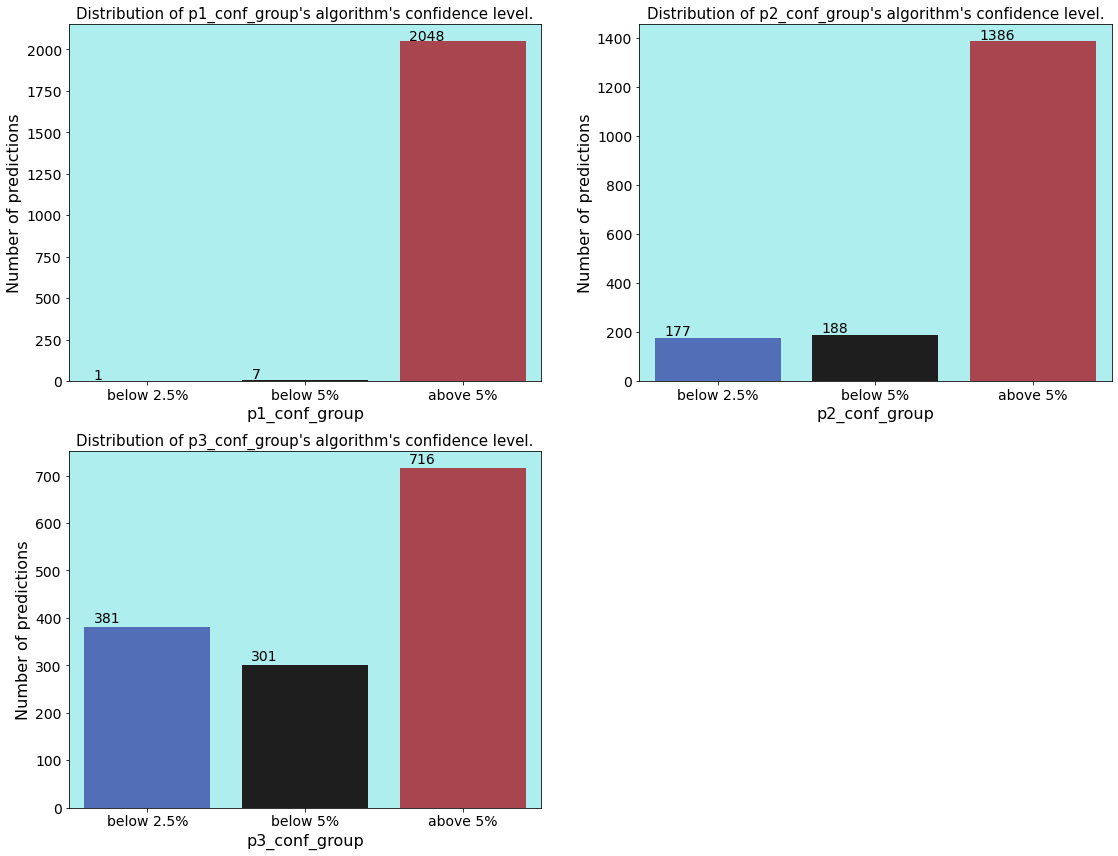

In [ ]:
# Plotting for the distribution of gender and agegroup among those diagnosed of alcoholism
conf_levels = ['p1_conf_group', 'p2_conf_group', 'p3_conf_group']
plt.figure(figsize=(16,12))

for feature,col in enumerate(conf_levels):    
    plt.subplot(2,2,feature + 1,  facecolor='paleturquoise')
    
    ax = sns.countplot(data=df, x = col, palette = 'icefire')

    plt.title(f"Distribution of {col}\'s algorithm's confidence level.", fontsize= 15)
    plt.xlabel(col, fontsize= 16)
    plt.ylabel("Number of predictions", fontsize= 16)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
   


    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.06, p.get_height()+10), fontsize= 14)

plt.tight_layout()

plt.show()

---
### **Insight 1**

---

* After cleaning, the numerators in the rating_numerator column look moderate considering the denominator assigned.

* The confidence interval for p3 seems most stronger as it has about 49% of its prediction within a 5% margin of error and most of the 49% below 2.5%.

* The p1_conf algorithm seems to have the worst confidence level as most (99.6%) of its predictions fall above the 5% margin of error.

---



---
**Checking for how the models are able to correctly predict the breed of dogs**

---

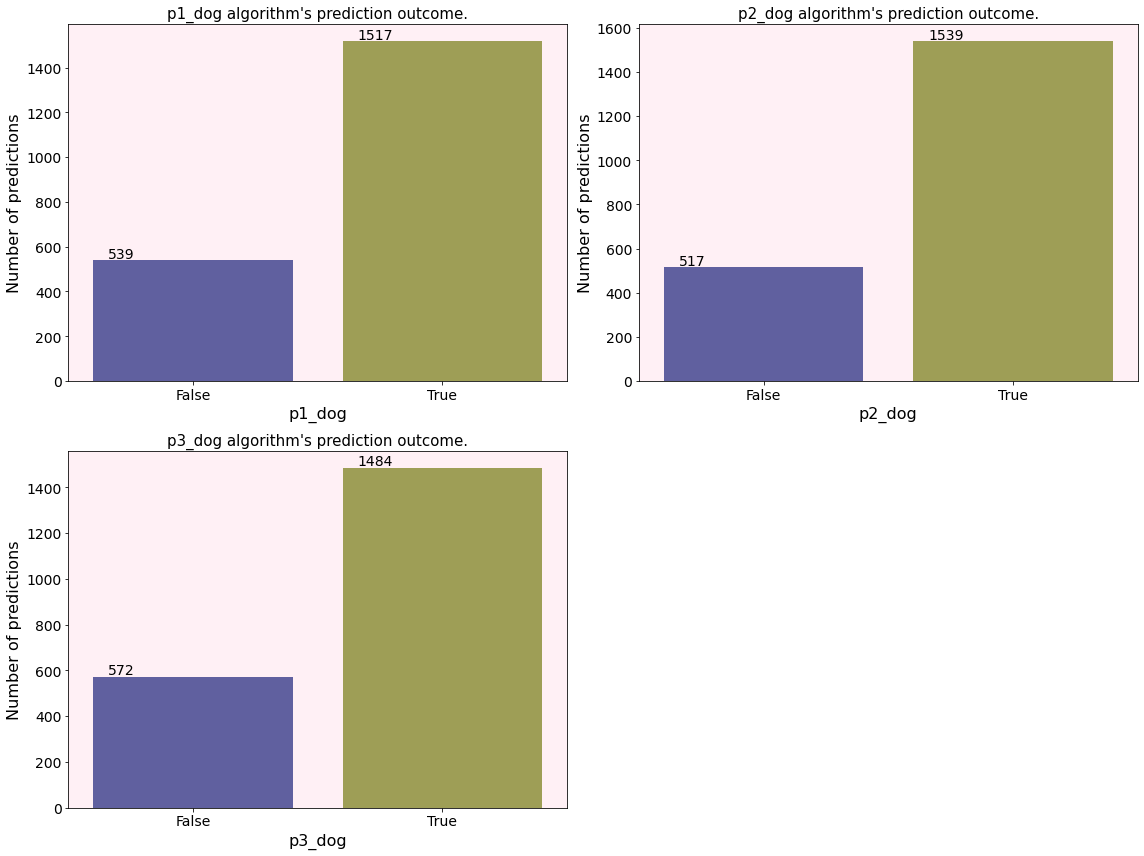

In [ ]:
# Plotting for the distribution of gender and agegroup among those diagnosed of alcoholism
conf_levels = ['p1_dog', 'p2_dog', 'p3_dog']
plt.figure(figsize=(16,12))

for feature,col in enumerate(conf_levels):    
    plt.subplot(2,2,feature + 1,  facecolor='lavenderblush')
    
    ax = sns.countplot(data=df, x = col, palette = 'gist_stern')

    plt.title(f"{col} algorithm's prediction outcome.", fontsize= 15)
    plt.xlabel(col, fontsize= 16)
    plt.ylabel("Number of predictions", fontsize= 16)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
   


    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.06, p.get_height()+10), fontsize= 14)

plt.tight_layout()

plt.show()

---
### **Insight 2**

---
  - p1_dog shows that the p1 algorithm has predicted about 74% of the breed of dogs correctly,the p3_dog algorithm predicted 72% whereas the p2_dog algorithm predicted about 76% correctly

---

## **Correlation**

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


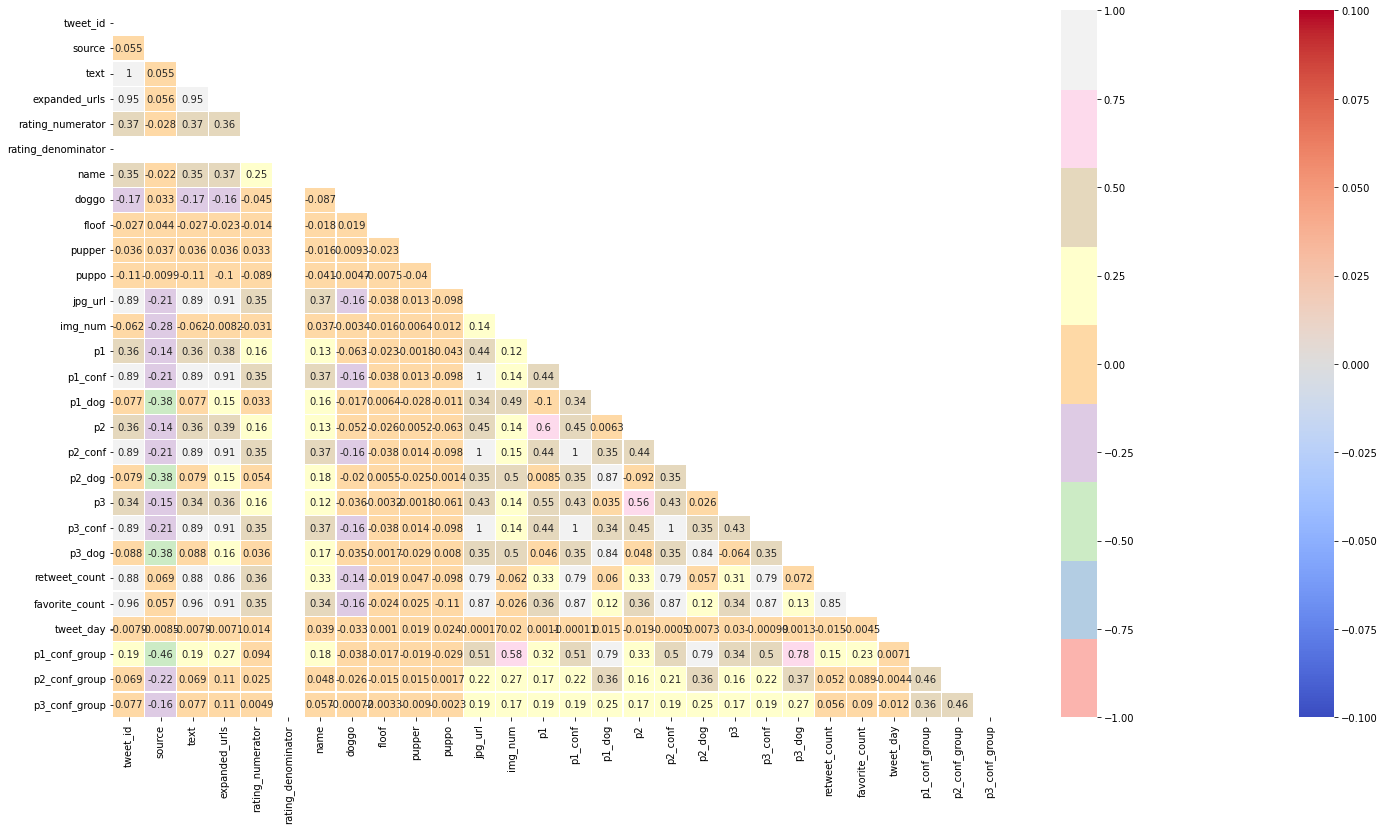

In [ ]:

# Plotting the correlation between variables using a heatmap
plt.figure(figsize=(25,13));
corr = df.apply(lambda x: pd.factorize(x)[0]).corr()
sns.heatmap(corr,annot=corr,cmap='coolwarm',fmt='.2g',mask=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='Pastel1', vmin=-1, vmax=1)

---
### **Insight 3**

---

* The correlation heatmap can help you find links between different variables. The numbers go from 0 to 1, and a positive number means a strong correlation, while a negative number means the opposite.
The range in each relationship is shown by a color code on the heatmap, which makes it easier to see.

* The correlation coefficient between retweet count and the favorite count is 0.85, which shows that there is a strong positive relationship between these two metrics.

---

## **Trends**
Plotting a pairplot to see the trend of tweets in relation to tweet day

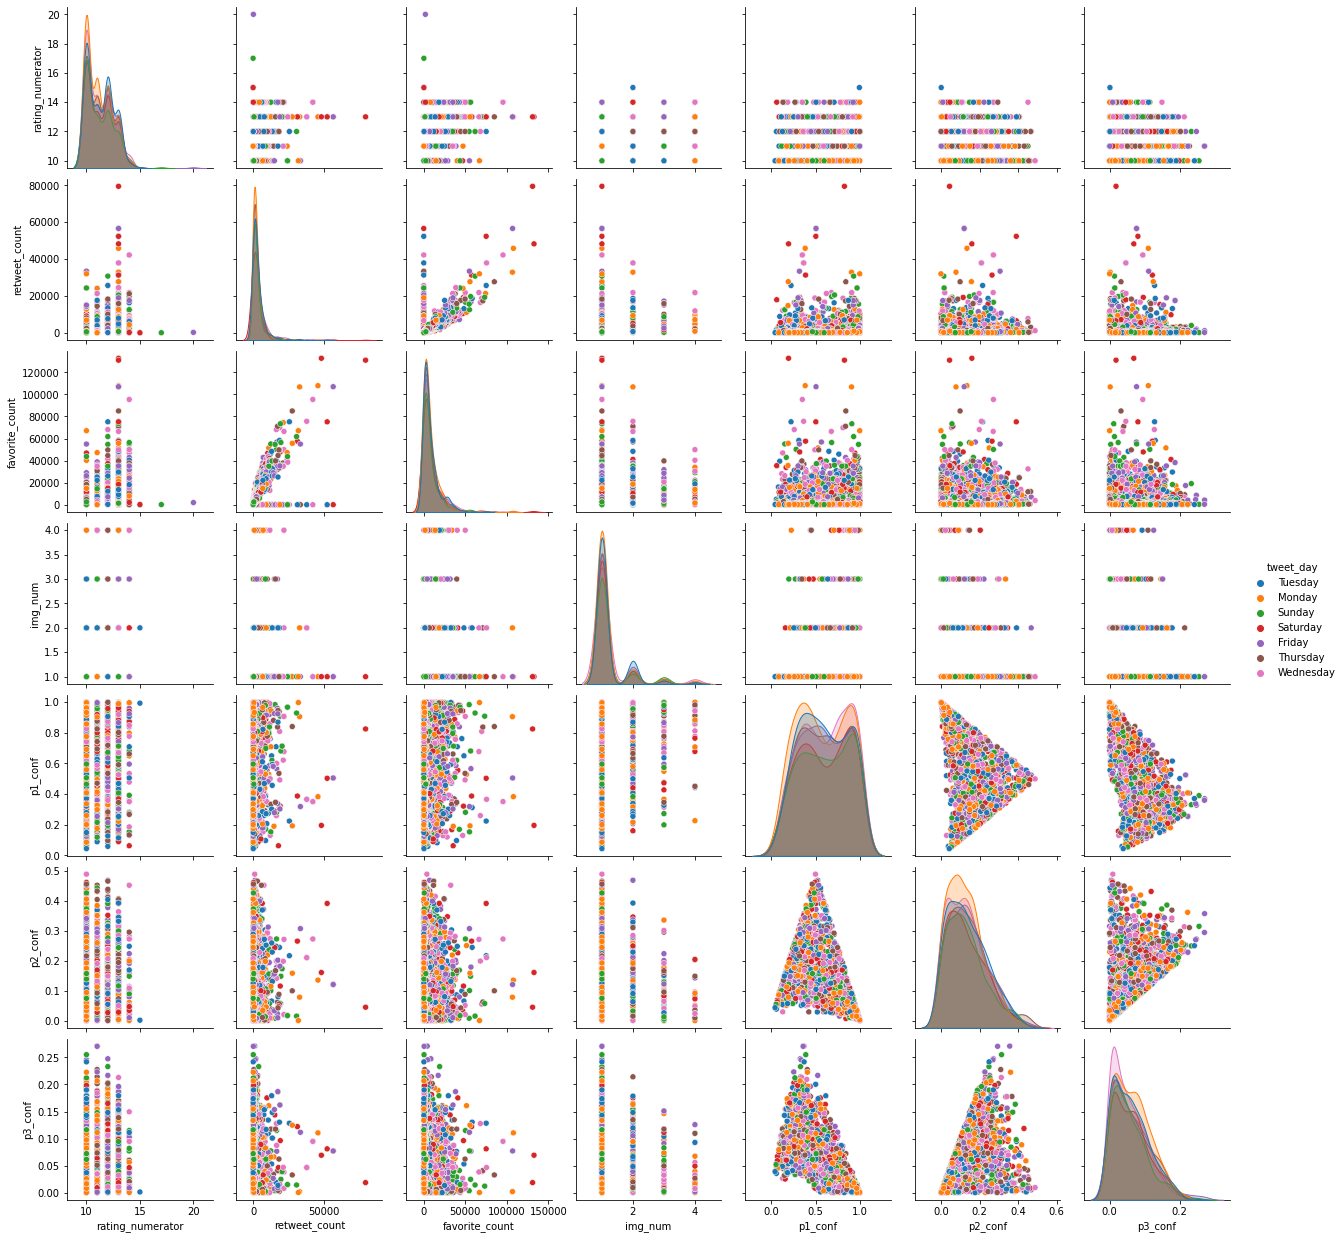

In [ ]:
sns.pairplot(df, vars=["rating_numerator", "retweet_count", "favorite_count", "img_num", "p1_conf", "p2_conf", "p3_conf"], hue='tweet_day'
             );

---
### **Insight 4**

---

The pairplot above was hued over tweet_day to show the strength of the relationship that exists between the dog ratings, retweets, favorites and img_num and dog predictions p1-p3.
Wednesday seems to be domineering in the visuals plotted above which might possibly imply Wednesdays have something to do with weratedogs tweets

---

**Generating word cloud to see which words are most popular in the tweets**

In [ ]:
tweets = np.array(df.text)
my_list = []
for tweet in tweets:
    my_list.append(tweet.replace("\n",""))

In [ ]:
mask = np.array(Image.open(requests.get('https://i.pinimg.com/564x/6a/29/f0/6a29f01afbdae9cb700c4a7dcde57d15.jpg', stream=True).raw))
text = my_list

In [ ]:
def gen_wc(text, mask):
    word_cloud = WordCloud(width = 100, height = 100, background_color='white', mask=mask).generate(str(text))
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='red')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

NB: The code above was modelled from https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e on how to create word cloud in python


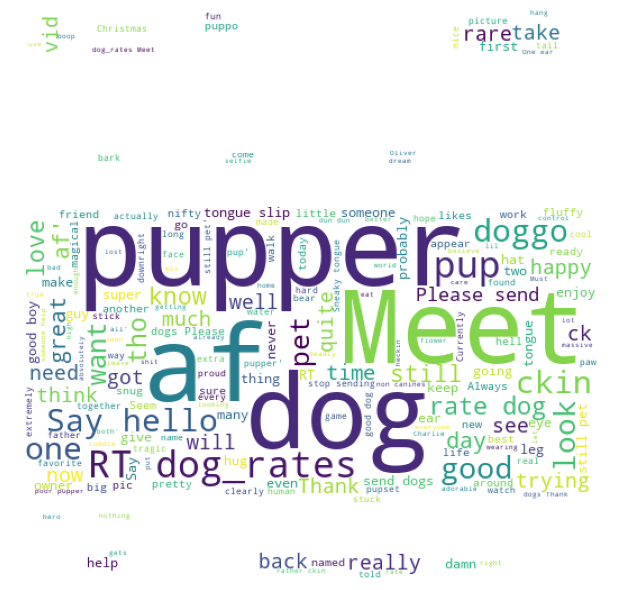

In [ ]:
gen_wc(text, mask)

---
### **Insight 5**

---
From the word cloud, **pupper, dog, meet and af** seems to be the most prevalent words

---

**Checking for the number of retweets and favourite_counts per weekday**

---
To learn which day had higher retweets and favourites
In this section we shall first group the data into the sum of retweets and favorites made for a tweet and the days these tweet were made while sorting them by decending other. After that a function would be created to visualise the outcome

In [ ]:
fm =final_merge.groupby(["tweet_day"],as_index=False)["retweet_count", "favorite_count"].sum()
fm.sort_values(by=["retweet_count"], ascending = False).head(7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,tweet_day,retweet_count,favorite_count
6,Wednesday,1305126.0,3177119.0
5,Tuesday,1175564.0,2833780.0
1,Monday,1110972.0,3048889.0
0,Friday,1027153.0,2574099.0
2,Saturday,990375.0,2471393.0
4,Thursday,943559.0,2482983.0
3,Sunday,853262.0,2323925.0


In [ ]:
#Creating a function for our chart
def top_rt(value1,value2,order):
    result1=fm.sort_values(value1, ascending = order)
    pl=sns.barplot(y=value2,x=value1,data=result1)
    title=plt.title ("{} per {}".format(value1, value2))
    yl=plt.ylabel("{}".format(value2))
    xl=plt.xlabel("{}".format(value1))
    return result1,pl,title,yl,xl

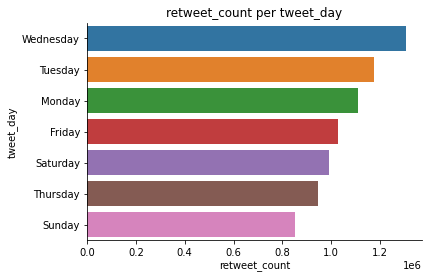

In [ ]:
top_rt('retweet_count','tweet_day', False)
sns.despine()

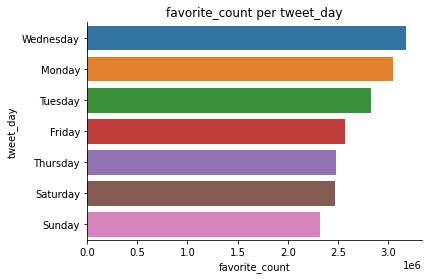

In [ ]:
#plot for top favourite counts by day of week
top_rt('favorite_count','tweet_day', False)
sns.despine()

---
### **Insight 6**

----

From the visuals, Wednesdays seems to have the most retweets and favourite counts.
Both retweets and favourite counts seems to have a positive correlation which explains the fact that people retweet tweets the like 

----